In [0]:
import numpy as np
from keras import losses, optimizers, models
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, concatenate, Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import h5py
import cv2

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
!ls "/content/gdrive/My Drive/Lung/"

full2.png  patch1.png  patch2.png  x_images.npz  y_labels.npz


In [0]:
# Load npz file containing image arrays
x_npz = np.load('/content/gdrive/My Drive/Lung/x_images.npz')
x = x_npz['arr_0'] # saved array in .npz named arr_o
# Load binary encoded labels
y_npz = np.load('/content/gdrive/My Drive/Lung/y_labels.npz')
y = y_npz['arr_0'] # saved array in .npz named arr_o

In [0]:
x.ndim

4

In [0]:
# split data 80% train, 20% test, default shuffle=True
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print('Training data: ', x_train.shape)
print('Testing data: ', x_test.shape)
x_train.ndim

Training data:  (528, 64, 64, 3)
Testing data:  (132, 64, 64, 3)


4

In [0]:
def build_model():
    inputs = Input((64, 64, 3))
    conv1_1 = Conv2D(16, 3, activation='relu', padding='same', name='conv1_1')(inputs)
    conv1_2 = Conv2D(16, 3, activation='relu', padding='same', name='conv1_2')(conv1_1)
    conv1_3 = Conv2D(16, 3, activation='relu', padding='same', name='conv1_3')(conv1_2)
    pool1 = MaxPooling2D(pool_size=2, name='pool1')(conv1_3)
    batch1 = BatchNormalization(name='batch1')(pool1)
    
    conv2_1 = Conv2D(32, 3, activation='relu', padding='same', name='conv2_1')(inputs)
    conv2_2 = Conv2D(32, 3, activation='relu', padding='same', name='conv2_2')(conv2_1) 
    conv2_3 = Conv2D(32, 3, activation='relu', padding='same', name='conv2_3')(conv2_2) 
    pool2 = MaxPooling2D(pool_size=2, name='pool2')(conv2_3)
    batch2 = BatchNormalization(name='batch2')(pool2)
    
    conv3_1 = Conv2D(64, 1, activation='relu', padding='same', name='conv3_1')(inputs)
    conv3_2 = Conv2D(64, 3, activation='relu', padding='same', name='conv3_2')(conv3_1)
    conv3_3 = Conv2D(64, 3, activation='relu', padding='same', name='conv3_3')(conv3_2)
    pool3 = MaxPooling2D(pool_size=2, name='pool3')(conv3_3)
    batch3 = BatchNormalization(name='batch3')(pool3)
    
    conv4_1 = Conv2D(128, 1, activation='relu', padding='same', name='conv4_1')(inputs)
    conv4_2 = Conv2D(128, 3, activation='relu', padding='same', name='conv4_2')(conv4_1)
    conv4_3 = Conv2D(128, 3, activation='relu', padding='same', name='conv4_3')(conv4_2)
    pool4 = MaxPooling2D(pool_size=2, name='pool4')(conv4_3)
    batch4 = BatchNormalization(name='batch4')(pool4)
    
    conv5_1 = Conv2D(8, 1, activation='relu', padding='same', name='conv5_1')(inputs)
    conv5_2 = Conv2D(8, 3, activation='relu', padding='same', name='conv5_2')(conv5_1)
    conv5_3 = Conv2D(8, 3, activation='relu', padding='same', name='conv5_3')(conv5_2)
    pool5 = MaxPooling2D(pool_size=2, name='pool5')(conv5_3)
    batch5 = BatchNormalization(name='batch5')(pool5)
    
    concate1 = concatenate([batch1, batch2, batch3, batch4, batch5], axis=-1, name='concate1')
    
    flatten = Flatten(name='flatten')(concate1)
    drop1 = Dropout(0.25, name='drop1')(flatten)
    dense1 = Dense(128, activation='relu', name='dense1')(drop1)
    dense2 = Dense(1, activation='sigmoid', name='dense2')(dense1)
    
    model = Model(inputs=[inputs], outputs=[dense2])
    return model

In [0]:
model = build_model()
model.summary()
print('The number of trainable weights: ', len(model.trainable_weights))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 64, 64, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
conv2_1 (Conv2D)                (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv3_1 (Conv2D)                (None, 64, 64, 64)   256         input_1[0][0]                    
__________________________________________________________________________________________________
conv4_1 (C

In [0]:
callbacks_list = [
    EarlyStopping(
        monitor='acc',
        patience=2, # stop training if not improve more than 2 epochs
    ),
    ModelCheckpoint(
        filepath='lung_mynet.h5',
        monitor='val_loss', # overwrite file when val_loss improve, save best model
        save_best_only=True,
    )
]

model.compile(optimizer=optimizers.Adam(lr=0.0001),
             loss=losses.binary_crossentropy,
             metrics=['acc'])

In [0]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow(x_train, y_train,
                                    batch_size=32)

In [0]:
# validation set
x_val = x_test[:100]
y_val = y_test[:100]
x_val.shape

(100, 64, 64, 3)

In [0]:
history = model.fit_generator(train_generator,
                    epochs=30,
                    steps_per_epoch=len(x_train)/32,      
                    #callbacks=callbacks_list,
                    validation_data=(x_val, y_val))

Epoch 1/30
17/16 [==============================] - 10s 607ms/step - loss: 1.5573 - acc: 0.5386 - val_loss: 6.8570 - val_acc: 0.5700
Epoch 2/30
17/16 [==============================] - 4s 219ms/step - loss: 0.5793 - acc: 0.7502 - val_loss: 6.9312 - val_acc: 0.5600
Epoch 3/30
17/16 [==============================] - 4s 219ms/step - loss: 0.3728 - acc: 0.8386 - val_loss: 6.6958 - val_acc: 0.5800
Epoch 4/30
17/16 [==============================] - 4s 219ms/step - loss: 0.1963 - acc: 0.9357 - val_loss: 6.8570 - val_acc: 0.5700
Epoch 5/30
17/16 [==============================] - 4s 218ms/step - loss: 0.1185 - acc: 0.9743 - val_loss: 6.6958 - val_acc: 0.5800
Epoch 6/30
17/16 [==============================] - 4s 219ms/step - loss: 0.0604 - acc: 0.9908 - val_loss: 7.1811 - val_acc: 0.5500
Epoch 7/30
17/16 [==============================] - 4s 220ms/step - loss: 0.0527 - acc: 0.9853 - val_loss: 6.6958 - val_acc: 0.5800
Epoch 8/30
17/16 [==============================] - 4s 220ms/step - loss: 0

In [0]:
model.save('lung_mynet.h5')

In [0]:
model = models.load_model('lung_mynet.h5')

In [0]:
history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

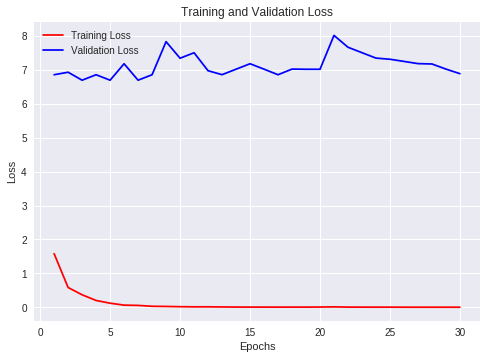

In [0]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

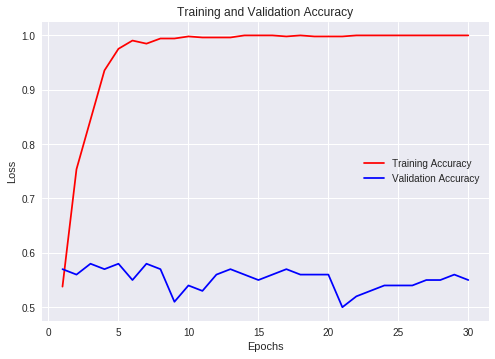

In [0]:
plt.clf() #clear previous plot

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [0]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow(x_test, y_test,
                                  batch_size=20)

In [0]:
model = models.load_model('lung_mynet.h5')
#model.summary()

In [0]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc: ', test_acc)

test acc:  0.5963983054635889


In [0]:
preds = model.predict(x_test)

for i in range(15):
    predict_label = preds[i]
    print('Predict: ', predict_label[0], 'Actual: ', y_test[i], '\n')

Predict:  1.0 Actual:  1 

Predict:  0.0 Actual:  0 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  0 

Predict:  0.0 Actual:  1 

Predict:  1.0 Actual:  0 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  1.0 Actual:  1 

Predict:  0.0 Actual:  1 

